In [94]:
%matplotlib inline
#%matplotlib notebook
import instrument
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle as pickle
import os

In [4]:
#series_list=[]

In [47]:
reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(100)
series.position=(2.54,2.00)
series_list.append(series)

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (2.14 +/- 0.01)us with std 0.07us


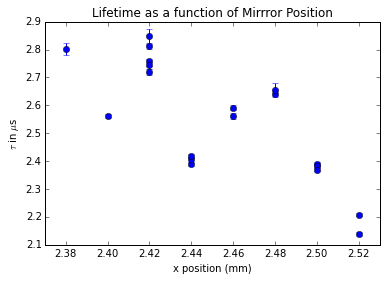

In [183]:
x_array=np.array([series.position[0] for series in series_list])
tau_array=np.array([series.tau_mean for series in series_list])*1e6
tau_uncertainties=np.array([series.tau_uncertainty for series in series_list])*1e6
left_lim,right_lim=min(x_array)-0.01,max(x_array)+0.01
plt.errorbar(x_array,tau_array,yerr=tau_uncertainties,fmt='o')
plt.xlim(left_lim,right_lim)
plt.xlabel(r"x position (mm)")
plt.ylabel(r"$\tau$ in $\mu$s")
plt.title(r"Lifetime as a function of Mirrror Position")
plt.savefig("Ringdown_Data/Mirrors_1_2_Horizontal_Scan_1/plot.png")

In [104]:
j=0
for series in new_list:
    file_name='horizontal_scan_%d_%1.2fmm.pkl' % (j,series.position[0])
    file_name=os.path.join('Mirrors_1_2_Horizontal_Scan_1',file_name)
    series.file_name=file_name
    series.save(overwrite=True)

In [192]:
#series_list=[]

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (2.19 +/- 0.01)us with std 0.06us


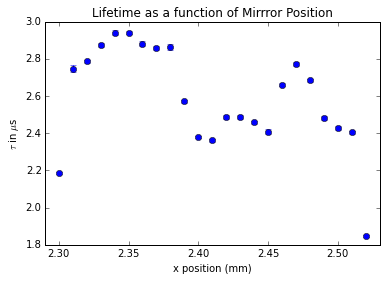

In [216]:
position=(2.30,2.00)

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(100)
series.position=position
series_list.append(series)

j=0
for series in series_list:
    file_name='horizontal_scan_%d_%1.2fmm.pkl' % (j,series.position[0])
    file_name=os.path.join('Mirrors_1_2_Horizontal_Scan_2',file_name)
    series.file_name=file_name
    series.save(overwrite=True)

x_array=np.array([series.position[0] for series in series_list])
tau_array=np.array([series.tau_mean for series in series_list])*1e6
tau_uncertainties=np.array([series.tau_uncertainty for series in series_list])*1e6
left_lim,right_lim=min(x_array)-0.01,max(x_array)+0.01
plt.errorbar(x_array,tau_array,yerr=tau_uncertainties,fmt='o')
plt.xlim(left_lim,right_lim)
plt.xlabel(r"x position (mm)")
plt.ylabel(r"$\tau$ in $\mu$s")
plt.title(r"Lifetime as a function of Mirrror Position")
plt.savefig("Ringdown_Data/Mirrors_1_2_Horizontal_Scan_2/plot.png")

In [220]:
reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(100)

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (2.33 +/- 0.01)us with std 0.07us
